In [7]:
#%pip install seaborn

import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [8]:
# ================================
# 1. CARGA Y PROCESAMIENTO DEL DATASET
# ================================

dataset_path = r"D:\Archivos Kmila\Proyecto de grado\dataset\B_1 UC MercedLand\UCMerced_LandUse\Images"
nclases = 21
img_size = (256, 256)

X = []
y = []
clase_dict = {}

for idx, clase in enumerate(sorted(os.listdir(dataset_path))):
    clase_path = os.path.join(dataset_path, clase)
    if os.path.isdir(clase_path):
        clase_dict[idx] = clase
        for img_name in os.listdir(clase_path):
            img_path = os.path.join(clase_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img)
                X.append(img_array)
                y.append(idx)
            except Exception as e:
                print(f"Error cargando imagen {img_path}: {e}")

X = np.array(X).astype('float32') / 255.0
y = np.array(y)

# División 80-10-10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# One-hot encoding
y_train_cat = to_categorical(y_train, nclases)
y_val_cat = to_categorical(y_val, nclases)
y_test_cat = to_categorical(y_test, nclases)

print(f"Training data shape: {X_train.shape}, {y_train_cat.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val_cat.shape}")
print(f"Test data shape: {X_test.shape}, {y_test_cat.shape}")

Training data shape: (1680, 256, 256, 3), (1680, 21)
Validation data shape: (210, 256, 256, 3), (210, 21)
Test data shape: (210, 256, 256, 3), (210, 21)


In [9]:
# ================================
# 2. DEFINICIÓN DEL MODELO CNN
# ================================

cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(21, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# ================================
# 3. ENTRENAMIENTO DEL MODELO
# ================================

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

history = cnn.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_val, y_val_cat),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)


c:\Users\kilig\radioconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\kilig\radioconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.1190 - loss: 3.5418 - val_accuracy: 0.0667 - val_loss: 5.2847 - learning_rate: 0.0010
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.1923 - loss: 3.0205 - val_accuracy: 0.0571 - val_loss: 7.1786 - learning_rate: 0.0010
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.2536 - loss: 2.6106 - val_accuracy: 0.0476 - val_loss: 6.1429 - learning_rate: 0.0010
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.2964 - loss: 2.3236 - val_accuracy: 0.0571 - val_loss: 7.3626 - learning_rate: 0.0010
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.3405 - loss: 2.1266 - val_accuracy: 0.0667 - val_loss: 5.4164 - learning_rate: 0.0010
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.3774 - loss: 1.9541 - val_accuracy: 0.0762 - val_loss: 4.5028 - learning_rate: 0.0010
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.4161 - loss: 1.8474 - 

In [10]:
# ================================
# 4. EVALUACIÓN DEL MODELO
# ================================

train_loss, train_accuracy = cnn.evaluate(X_train, y_train_cat)
val_loss, val_accuracy = cnn.evaluate(X_val, y_val_cat)
test_loss, test_accuracy = cnn.evaluate(X_test, y_test_cat)

print(f"\nTraining Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 400ms/step - accuracy: 0.9167 - loss: 0.2876
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.8095 - loss: 0.5077
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.8714 - loss: 0.5317

Training Accuracy: 91.67%
Validation Accuracy: 80.95%
Test Accuracy: 87.14%


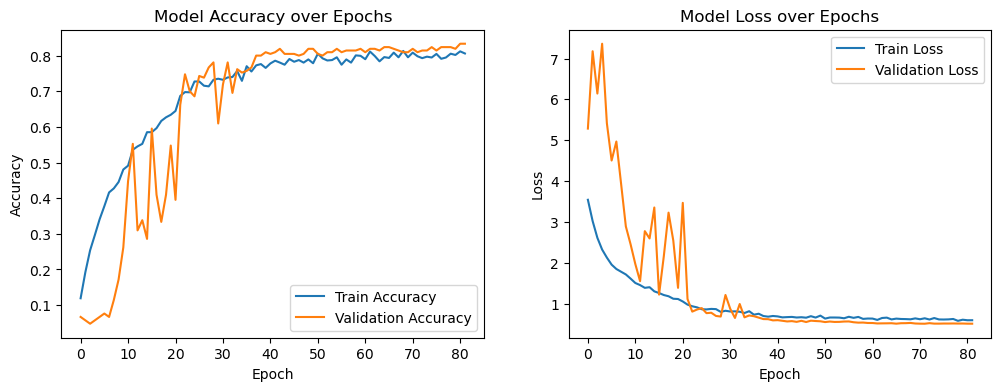

In [11]:
# ================================
# 5. GRÁFICAS DE ENTRENAMIENTO
# ================================

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step


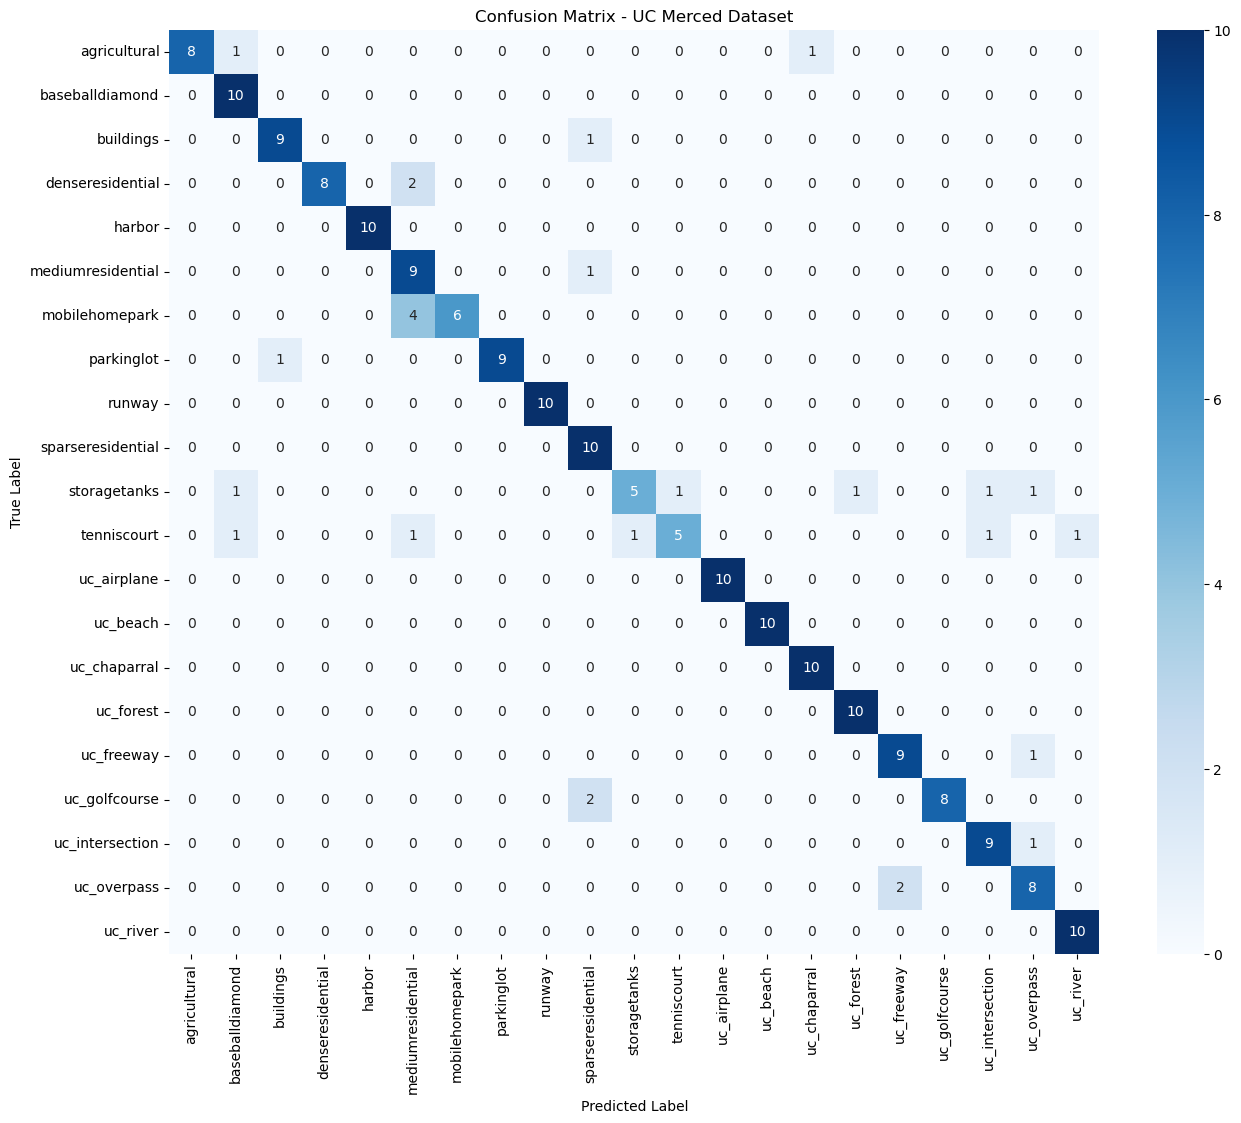

In [12]:
# ================================
# 6. MATRIZ DE CONFUSIÓN
# ================================

y_pred = np.argmax(cnn.predict(X_test), axis=-1)
y_true = np.argmax(y_test_cat, axis=-1)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(clase_dict.values()), 
            yticklabels=list(clase_dict.values()))
plt.title('Confusion Matrix - UC Merced Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
# ================================
# 7. PRECISIÓN POR CLASE
# ================================

print("\nAccuracy por clase:")
for i in range(nclases):
    mask = (y_true == i)
    if np.sum(mask) > 0:
        acc = accuracy_score(y_true[mask], y_pred[mask])
        print(f"{clase_dict[i]}: {acc*100:.2f}%")


Accuracy por clase:
agricultural: 80.00%
baseballdiamond: 100.00%
buildings: 90.00%
denseresidential: 80.00%
harbor: 100.00%
mediumresidential: 90.00%
mobilehomepark: 60.00%
parkinglot: 90.00%
runway: 100.00%
sparseresidential: 100.00%
storagetanks: 50.00%
tenniscourt: 50.00%
uc_airplane: 100.00%
uc_beach: 100.00%
uc_chaparral: 100.00%
uc_forest: 100.00%
uc_freeway: 90.00%
uc_golfcourse: 80.00%
uc_intersection: 90.00%
uc_overpass: 80.00%
uc_river: 100.00%
